In [ ]:
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))   # Used colab GPU for efficient and faster training

Num GPUs Available:  1


In [6]:
########################task1 importing all libraries
import gym
import numpy as np
from tensorflow.keras import layers
import tensorflow as tf
import random
from collections import deque
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
#Selecting an atari environment

env = gym.make('CartPole-v1')   #selected cartpole atari game
state_size = env.observation_space.shape[0]    #the state space consists of 4 variables: cart position, cart velocity, pole angle, and pole velocity at the tip
action_size = env.action_space.n    #there are 2 possible actions: move the cart to the left or move the cart to the right.

In [3]:

# Hyperparameters
gamma = 0.99    #Discount factor for future rewards.
epsilon = 1.0      #The initial exploration rate, starting at 1.0 means the agent will initially take random actions to explore the environment.
epsilon_min = 0.01   #The minimum value that epsilon can decay to. This ensures that the agent always has a small chance of exploring new actions.
epsilon_decay = 0.995    #reducing the exploration rate as the agent learns more about the environment.
learning_rate = 0.005   #smaller the lr, more iterations needed but ensures stready stable learning
batch_size = 32     #Number of experiences sampled for each training update.
memory_size = 2000   # The capacity of the replay memory, which stores past experiences (state, action, reward, next state) 
target_update_freq = 10   #Frequency of updating the target network to stabilize training.


In [4]:

######################Task 2 : Build the Q-network
def build_q_network(state_size, action_size):                        #takes input and output layer sizes
    model = tf.keras.Sequential([                                    #This creates a sequential model, which is a linear stack of layers.
        layers.Dense(24, input_dim=state_size, activation='relu'),  #maps input layers with 24 layers and activation function is Rectified linear unit(RELU) to introduce non linearity
        layers.Dense(24, activation='relu'),                       #To stack multiple layers
        layers.Dense(action_size, activation='linear')              #Adds output layers fully with action using linearity to provide accurate Q value
    ]) 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  #Adam optimizer is popular due to its adaptive learning rate properties.

                  loss='mse')                   #loss function is mean squared error
    return model

In [7]:

# Initialize the Q-network and the target network
q_network = build_q_network(state_size, action_size)    #Primary Q network
target_network = build_q_network(state_size, action_size) #target network, initially identical but overtime prevents divergence
target_network.set_weights(q_network.get_weights())     #Periodically updating the target network with the Q-network's weights helps reduce the risk of divergence and provides more stable training targets.

# Memory to store experiences
memory = deque(maxlen=memory_size)  #double ended queue to store past experiences with memory size


/home/aakashgpt/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
#all important functions for training process
def remember(state, action, reward, next_state, done):    #takes five args current state, current action, reward recieved, next state after action and done if episode is finished
    memory.append((state, action, reward, next_state, done))   #appends data to memoru deque
 
def act(state, epsilon):
    if np.random.rand() <= epsilon:            #selects random number between 0 and 1
        return random.randrange(action_size)     # if condition is met, return random action
    if isinstance(state, tuple) and len(state) == 2 and isinstance(state[0], np.ndarray):
        state=state[0]
    q_values = q_network.predict(np.expand_dims(state, axis=0))    #predicts q value using q-network giving state as arg
    return np.argmax(q_values[0])   #return maximum q value

def replay():
    if len(memory) < batch_size:   #if batch size is more than memory left then abort as to ensure to start only when enough stored experiences to sample full batch 
        return
    minibatch = random.sample(memory, batch_size)
    states, targets_f = [], []
    for state, action, reward, next_state, done in minibatch:
        target = reward     #immediate reward is used as initial target
        if not done:
            target += gamma * np.amax(target_network.predict(np.expand_dims(next_state, axis=0))[0])   #add discounted maximum future rewards
        if isinstance(state, tuple) and len(state) == 2 and isinstance(state[0], np.ndarray):
            state=state[0]
        state_expanded=np.expand_dims(state,axis=0)
        # print(state_expanded)
        target_f = q_network.predict(state_expanded)
        target_f[0][action] = target    #target q value updated
        states.append(state)
        targets_f.append(target_f[0])
    q_network.fit(np.array(states), np.array(targets_f), epochs=1, verbose=0)   #updating Q network

def update_target_network():
    target_network.set_weights(q_network.get_weights())

In [9]:
########Task 3 : Training
action=act(env.reset(),epsilon)   #initial action using reset
episodes = 50    #taken only 50 episodes due to GPU and time limitation
training_reward=[]
for e in range(episodes):   #main training loop
    state = env.reset()
    done = False
    total_reward = 0
    while not done:   #episode loop
        action = act(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        replay() 
    update_target_network()   #updating the target network
    if epsilon > epsilon_min:   #Decays epsilon to reduce exploration over time, but ensures it does not go below epsilon_min
        epsilon *= epsilon_decay
    training_reward.append(total_reward)
    print(f"episode: {e}/{episodes}, score: {total_reward}, epsilon: {epsilon:.2}")

q_network.save_weights('dqn_cartpole.weights.h5')   #saving trained q network to a file


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 29ms/step
episode: 48/50, score: 10.0, epsilon: 0.78
1/1 [==============================] - 0s 27ms/step
episode: 49/50, score: 76.0, epsilon: 0.78


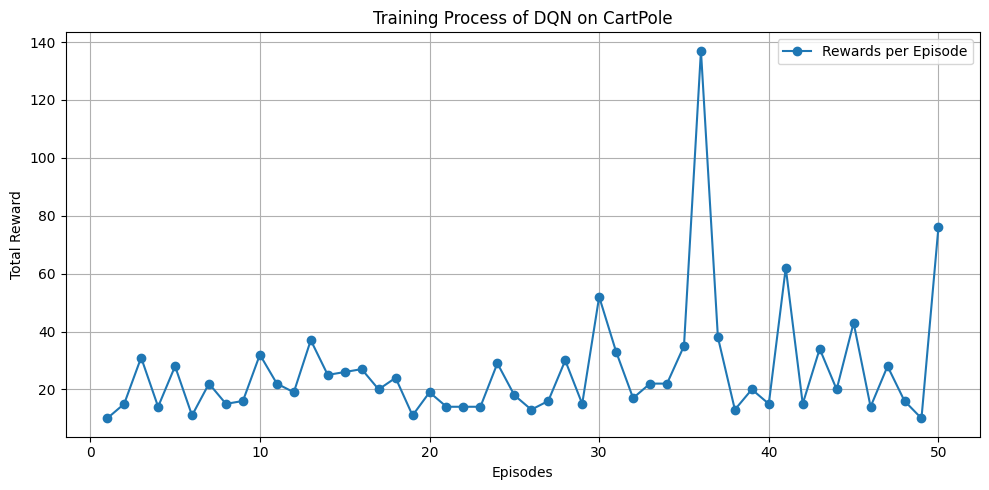

In [10]:
#plotting the training process
plt.figure(figsize=(10, 5))
plt.plot(range(1, episodes + 1), training_reward, label='Rewards per Episode', marker='o')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Training Process of DQN on CartPole')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 24ms/step
Evaluation Episode 1: Total reward = 256.0
1/1 [==============================] - 0s 22ms/step
Evaluation Episode 2: Total reward = 300.0
1/1 [==============================] - 0s 20ms/step
Evaluation Episode 3: Total reward = 355.0
1/1 [==============================] - 0s 17ms/step
Evaluation Episode 4: Total reward = 284.0
1/1 [==============================] - 0s 21ms/step
Evaluation Episode 5: Total reward = 240.0
1/1 [==============================] - 0s 29ms/step
Evaluation Episode 6: Total reward = 342.0
1/1 [==============================] - 0s 20ms/step
Evaluation Episode 7: Total reward = 500.0
1/1 [==============================] - 0s 18ms/step
Evaluation Episode 8: Total reward = 404.0
1/1 [==============================] - 0s 22ms/step
Evaluation Episode 9: Total reward = 184.0
1/1 [==============================] - 0s 33ms/step
Evaluation Episode 10: Total reward = 406.0
Average Reward over 10 episodes: 327.1


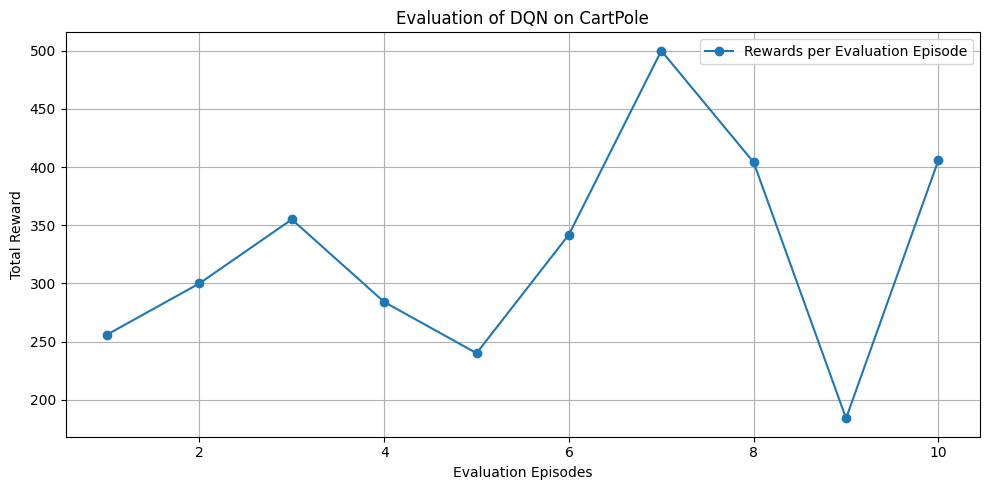

Average Reward after training: 327.1


In [11]:
###Evaluation of the trained model
# Load the model weights
q_network.load_weights('dqn_cartpole.weights.h5')

# Evaluate the model's performance and plot the results
def evaluate_model(episodes=10):
    total_rewards = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            if isinstance(state, tuple) and len(state) == 2 and isinstance(state[0], np.ndarray):
                state=state[0]
            action = np.argmax(q_network.predict(np.expand_dims(state, axis=0))[0])
            next_state, reward, done, _ = env.step(action)
            state = next_state
            total_reward += reward
        total_rewards.append(total_reward)
        print(f"Evaluation Episode {episode + 1}: Total reward = {total_reward}")
    avg_reward = np.mean(total_rewards)
    print(f"Average Reward over {episodes} episodes: {avg_reward}")

    # Plotting the evaluation process (reward vs episodes)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, episodes + 1), total_rewards, label='Rewards per Evaluation Episode', marker='o')
    plt.xlabel('Evaluation Episodes')
    plt.ylabel('Total Reward')
    plt.title('Evaluation of DQN on CartPole')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return avg_reward

average_reward = evaluate_model(episodes=10)
print(f"Average Reward after training: {average_reward}")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 29ms/step
Episode 87: Total reward = 453.0
1/1 [==============================] - 0s 28ms/step
Episode 88: Total reward = 380.0
1/1 [==============================] - 0s 34ms/step
Episode 89: Total reward = 268.0
1/1 [==============================] - 0s 26ms/step
Episode 90: Total reward = 311.0
1/1 [==============================] - 0s 23ms/step
Episode 91: Total reward = 196.0
1/1 [==============================] - 0s 26ms/step
Episode 92: Total reward = 409.0
1/1 [==============================] - 0s 30ms/step
Episode 93: Total reward = 228.0
1/1 [==============================] - 0s 26ms/step
Episode 94: Total reward = 460.0
1/1 [==============================] - 0s 27ms/step
Episode 95: Total reward = 425.0
1/1 [==============================] - 0s 24ms/step
Episode 96: Total reward = 474.0
1/1 [==============================] - 0s 25ms/step
Episode 97: Total reward = 292.0
1/1 [=========

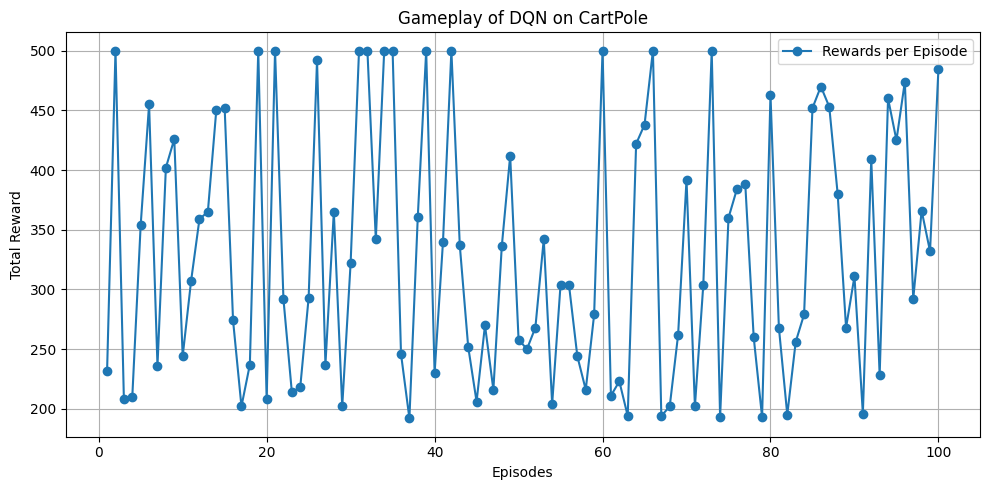

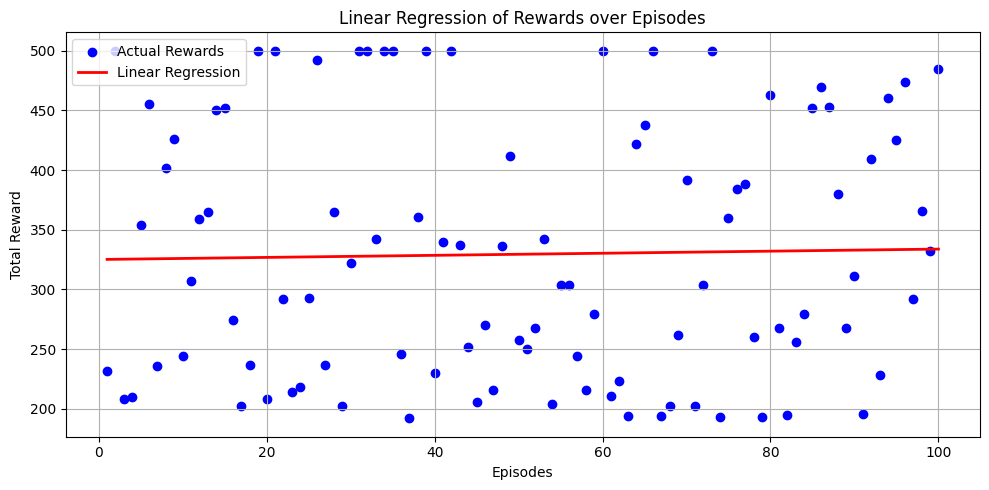

Linear Regression Coefficients: 0.09


In [12]:
#demostrating gameplay
num_episodes_to_play = 100
trained_reward=[]
for episode in range(num_episodes_to_play):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        if isinstance(state, tuple) and len(state) == 2 and isinstance(state[0], np.ndarray):
            state=state[0]
        action = np.argmax(q_network.predict(np.expand_dims(state, axis=0))[0])
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
    trained_reward.append(total_reward)
    print(f"Episode {episode + 1}: Total reward = {total_reward}")

#plotting the post-training reward
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_episodes_to_play + 1), trained_reward, label='Rewards per Episode', marker='o')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Gameplay of DQN on CartPole')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Linear regression of rewards over episodes
X = np.array(range(1, num_episodes_to_play + 1)).reshape(-1, 1)
y = np.array(trained_reward)
regressor = LinearRegression()
regressor.fit(X, y)
y_pred = regressor.predict(X)

plt.figure(figsize=(10, 5))
plt.scatter(X, y, color='blue', label='Actual Rewards')
plt.plot(X, y_pred, color='red', linewidth=2, label='Linear Regression')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Linear Regression of Rewards over Episodes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Linear Regression Coefficients: {regressor.coef_[0]:.2f}")

env.close()  # Close the environment after rendering